delta_nu/2 instead of delta_nu

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from PyAstronomy import pyasl
from datetime import datetime
import celerite
from celerite import terms
from scipy.optimize import minimize
from scipy.signal import find_peaks
from astropy.timeseries import LombScargle
from datetime import timedelta, date
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

from NEID_solar_functions import *
from GP_kernels import *


In [25]:
SONG = np.loadtxt('./lib/sun_SONG_full_lowess_filtered_final_used.dat')
bjd = SONG[:,0]
rv = SONG[:,1]

In [26]:
start_date = datetime(2018, 5, 27)
end_date = datetime(2018, 7, 16)

T1 = pyasl.jdcnv(start_date)
T2 = pyasl.jdcnv(end_date)

idx_bjd = (bjd>T1) & (bjd<T2+1)
t = (bjd[idx_bjd]-min(bjd[idx_bjd]))*24*60
y = rv[idx_bjd]
yerr = np.ones(len(t))*0.7

In [27]:
# start_date = datetime(2018, 5, 27)
# end_date = datetime(2018, 6, 10)

# for date in daterange(start_date, end_date):
#     T1 = pyasl.jdcnv(date)
#     idx_bjd = (bjd>T1) & (bjd<T1+1)
    
#     t = (bjd[idx_bjd]-min(bjd[idx_bjd]))*24*60
#     y = rv[idx_bjd]
#     yerr = np.ones(len(t))*0.7
    
#     t0 = t
#     y0 = y
#     yerr0 = yerr

In [28]:
# idx = np.sort(random.sample(range(0, len(t)), 10000))
# idx = np.arange(0, len(t), len(t)/2000)
idx = np.sort(random.sample(range(0, len(t)), 10000))
# idx = np.array([int(i) for i in idx])

In [29]:
t = t[idx] - min(t[idx])
y = y[idx]
yerr = yerr[idx]

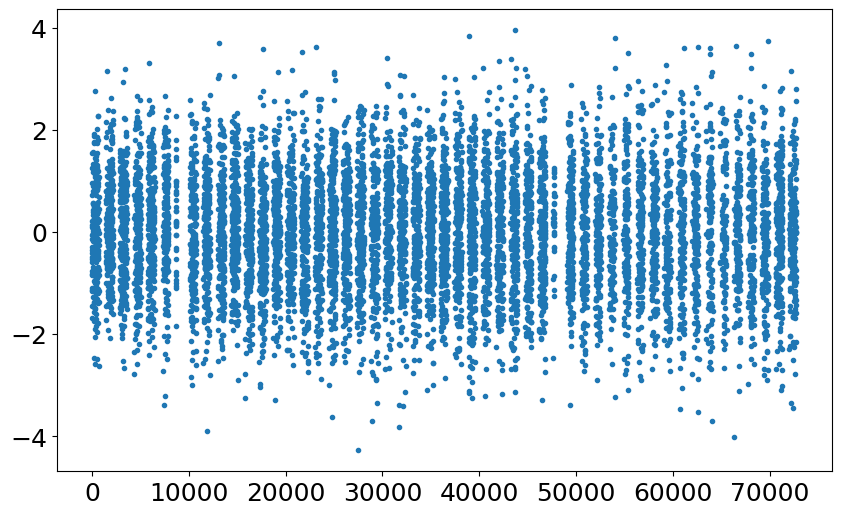

In [30]:
plt.rcParams.update({'font.size': 18})
fig = plt.figure(figsize=(10, 6))
plt.plot(t, y, '.')

In [31]:
import jax
import jax.numpy as jnp
from tinygp import kernels, GaussianProcess
import tinygp

jax.config.update("jax_enable_x64", True)


In [32]:
# Factor to convert uHz to minute^-1
uHz_conv = 1e-6 * 60

def build_gp(theta, X):

    # We want most of our parameters to be positive so we take the `exp` here
    # Note that we're using `jnp` instead of `np`
    Q = jnp.exp(theta["log_Q"])
    A = jnp.exp(theta["log_A"])
    W = jnp.exp(theta["log_W"])
    # sigma = jnp.exp(theta["log_sigma"])
    nu_max = jnp.exp(theta["log_nu_max"])
    delta_nu = jnp.exp(theta["log_delta_nu"])
    epsilon = theta["epsilon"]

    # Construct the kernel by multiplying and adding `Kernel` objects
    
    kernel = 0     
    N = 25 # 25*135/2=1620
    for i in range(N):
        omega = 2*np.pi*(nu_max + (-(N-1)/2+i)*delta_nu/2 + epsilon)*uHz_conv
        sigma = A*jnp.exp( - (i*delta_nu/2 + epsilon)**2 / (2*W**2) ) # uHz_conv is cancelled out; change A/Q**2 to A**2
        kernel += tinygp.kernels.quasisep.SHO(omega, Q, sigma)
            
    return GaussianProcess(kernel, X, diag=jnp.exp(theta["log_diag"])), kernel
    # return GaussianProcess(
    #     kernel, X) 

def neg_log_likelihood(theta, X, y):
    gp, _ = build_gp(theta, X)
    return -gp.log_probability(y)


theta_init = {
    "log_diag": np.log(0.5),
    "log_Q": np.log(400),
    "log_A": np.log(0.2),
    "log_W": np.log(300),
    "log_nu_max": np.log(3080),
    "log_delta_nu": np.log(135),
    "epsilon": np.float64(0.0)
}


# `jax` can be used to differentiate functions, and also note that we're calling
# `jax.jit` for the best performance.
obj = jax.jit(jax.value_and_grad(neg_log_likelihood))

print(f"Initial negative log likelihood: {obj(theta_init, t, y)[0]}")
print(
    f"Gradient of the negative log likelihood, wrt the parameters:\n{obj(theta_init, t, y)[1]}"
)

Initial negative log likelihood: 17246.054950542395
Gradient of the negative log likelihood, wrt the parameters:
{'epsilon': DeviceArray(-9.83773831, dtype=float64), 'log_A': DeviceArray(-455.35894104, dtype=float64), 'log_Q': DeviceArray(181.58856806, dtype=float64), 'log_W': DeviceArray(-945.76956605, dtype=float64), 'log_delta_nu': DeviceArray(5177.71709581, dtype=float64), 'log_diag': DeviceArray(-5502.53863507, dtype=float64), 'log_nu_max': DeviceArray(-36533.06693713, dtype=float64)}


In [10]:
# Factor to convert uHz to minute^-1
uHz_conv = 1e-6 * 60
amp0, mu0, sig0 = np.array([ 5.46875972e-03,  3.08082489e+03, 3.05370933e+02])    
amp0 *= 6e1
nu_max = mu0
delta_nu = 135
epsilon = 0
W = sig0
Q = 400
    
def build_gp(theta, X):

    # We want most of our parameters to be positive so we take the `exp` here
    # Note that we're using `jnp` instead of `np`
    # Q = jnp.exp(theta["log_Q"])
    A = jnp.exp(theta["log_A"])
    # W = jnp.exp(theta["log_W"])
    # # sigma = jnp.exp(theta["log_sigma"])
    # nu_max = jnp.exp(theta["log_nu_max"])
    # delta_nu = jnp.exp(theta["log_delta_nu"])
    # epsilon = theta["epsilon"]

    # Construct the kernel by multiplying and adding `Kernel` objects
    
    kernel = 0     
    N = 19 # 25*135/2=1620
    for i in range(N):
        omega = 2*np.pi*(nu_max + (-(N-1)/2+i)*delta_nu/2 + epsilon)*uHz_conv
        sigma = A*jnp.exp( - (i*delta_nu/2 + epsilon)**2 / (2*W**2) ) # uHz_conv is cancelled out; change A/Q**2 to A**2
        kernel += tinygp.kernels.quasisep.SHO(omega, Q, sigma)
            
    return GaussianProcess(kernel, X, diag=0.51), kernel
    # return GaussianProcess(kernel, X), kernel

def neg_log_likelihood(theta, X, y):
    gp, _ = build_gp(theta, X)
    return -gp.log_probability(y)


theta_init = {
    # "log_diag": np.log(0.5),
    # "log_Q": np.log(400),
    "log_A": np.log(amp0),
    # "log_W": np.log(300),
    # "log_nu_max": np.log(3080),
    # "log_delta_nu": np.log(135),
    # "epsilon": np.float64(0.0)
}


# `jax` can be used to differentiate functions, and also note that we're calling
# `jax.jit` for the best performance.
obj = jax.jit(jax.value_and_grad(neg_log_likelihood))

print(f"Initial negative log likelihood: {obj(theta_init, t, y)[0]}")
print(
    f"Gradient of the negative log likelihood, wrt the parameters:\n{obj(theta_init, t, y)[1]}"
)

Initial negative log likelihood: 122936.81752295786
Gradient of the negative log likelihood, wrt the parameters:
{'log_A': DeviceArray(-10677.7448301, dtype=float64)}


In [11]:
# jnp.hstack((jnp.log(jnp.array([100, 0.1, 0.8, 0.8, 0.1, 0.1])), jnp.array(-0.1)))

In [33]:
theta_init

{'log_diag': -0.6931471805599453,
 'log_Q': 5.991464547107982,
 'log_A': -1.6094379124341003,
 'log_W': 5.703782474656201,
 'log_nu_max': 8.03268487596762,
 'log_delta_nu': 4.90527477843843,
 'epsilon': 0.0}

In [13]:
# # lower_bounds = jnp.hstack((jnp.log(jnp.array([100, 0.1, 0.8, 0.8, 0.1, 0.1])), jnp.array(-0.1)))
# # upper_bounds = jnp.hstack((jnp.log(jnp.array([1000, 1, 1.6, 1.6, 5, 5])), jnp.array(0.1)))
# lower_bounds = jnp.log(jnp.array([100,  120, 0.5, 2500, 0.1, 0.1, 0.1]))
# upper_bounds = jnp.log(jnp.array([1000, 150, 1,   3500,  10,  10,  10]))
# bounds = (lower_bounds, upper_bounds)
# bounds

In [14]:
# bounds = {
#     "mean": np.float64([-1, 1]),
#     "log_diag": np.log([0.1, 1]),
#     "log_omega": (np.log([0.8, 0.8]), np.log([1.6, 1.6])),
#     "log_Q": (np.log([100, 100]), np.log([1000, 1000])),
#     "log_sigma": (np.float64([0.1, 0.1]), np.float64([1, 1])),
# }

In [15]:
# epsilon_l, epsilon_h = jnp.float64([-0.1, 0.1])
# bounds_l = jnp.log(jnp.array([1e-2, 3e2, 300, 134, 0.4, 3050.0]))
# bounds_h = jnp.log(jnp.array([1,    6e2, 310, 136, 0.6, 3100.0]))
# lower_bounds, upper_bounds = jnp.hstack((epsilon_l, bounds_l)), jnp.hstack((epsilon_h, bounds_h))
# bounds = (lower_bounds, upper_bounds)
# bounds

In [16]:
# lower_bounds = jnp.array([jnp.log(10**1), jnp.log(10**2),  jnp.log(100),  jnp.log(130), jnp.log(0.5), jnp.log(2500)])
# upper_bounds = jnp.array([25,             jnp.log(10**4),  10,            jnp.log(140), jnp.log(1),   jnp.log(3500)])
# bounds = (lower_bounds, upper_bounds)
# bounds

In [34]:
w_init = jnp.zeros(len(theta_init))
lower_bounds = jnp.ones_like(w_init)* (-1)
upper_bounds = jnp.ones_like(w_init) * jnp.inf
bounds = (lower_bounds, upper_bounds)
bounds

(DeviceArray([-1., -1., -1., -1., -1., -1., -1.], dtype=float64),
 DeviceArray([inf, inf, inf, inf, inf, inf, inf], dtype=float64))

In [35]:
# lower_bounds = jnp.log(jnp.array([1e-2, 3e2, 0.4]))
# upper_bounds = jnp.log(jnp.array([1,    6e2, 0.6]))
# bounds = (lower_bounds, upper_bounds)
# bounds

In [36]:
import jaxopt
solver = jaxopt.ScipyBoundedMinimize(fun=neg_log_likelihood)
soln = solver.run(theta_init, bounds=bounds, X=t, y=y)
print(f"Final negative log likelihood: {soln.state.fun_val}")

Final negative log likelihood: 14713.008073199511


In [37]:
soln.params

{'epsilon': DeviceArray(0.01018959, dtype=float64),
 'log_A': DeviceArray(-1., dtype=float64),
 'log_Q': DeviceArray(6.68586748, dtype=float64),
 'log_W': DeviceArray(5.86912243, dtype=float64),
 'log_delta_nu': DeviceArray(4.91142314, dtype=float64),
 'log_diag': DeviceArray(-0.10917353, dtype=float64),
 'log_nu_max': DeviceArray(8.27179406, dtype=float64)}

In [38]:
for key, value in soln.params.items():
    print(key[4:], np.exp(value))
    
# print(1/(np.exp(soln.params['log_nu_max'])*uHz_conv))

lon 1.0102416798382339
A 0.3678794411714424
Q 801.0052344790802
W 353.93823712011
delta_nu 135.8325863313002
diag 0.8965748228233289
nu_max 3911.9610030724853


In [22]:
# np.exp(soln.params['log_A']) * jnp.exp( - (1*np.exp(soln.params['log_delta_nu'])/2 + soln.params['epsilon'])**2 / (2*np.exp(soln.params['log_W'])**2) )

In [23]:
# for j in range(13):
#     coeff = jnp.exp( - (j*np.exp(soln.params['log_delta_nu'])/2 + soln.params['epsilon'])**2 / (2*np.exp(soln.params['log_W'])**2) )
#     print(coeff)

In [ ]:
x = np.linspace(min(t), max(t), 1000)
gp, kernel = build_gp(soln.params, t)
cond_gp = gp.condition(y, x).gp
pred_mean, pred_std = cond_gp.loc, cond_gp.variance

2023-04-06 13:01:10.679656: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:65] Constant folding an instruction is taking > 1s:

  pad.114 (displaying the full instruction incurs a runtime overhead. Raise your logging level to 4 or above).

This isn't necessarily a bug; constant-folding is inherently a trade-off between compilation time and speed at runtime.  XLA has some guards that attempt to keep constant folding from taking too long, but fundamentally you'll always be able to come up with an input program that takes a long time.

If you'd like to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
2023-04-06 13:01:11.007910: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:133] The operation took 1.328336549s
Constant folding an instruction is taking > 1s:

  pad.114 (displaying the full instruction incurs a runtime overhead. Raise your logging level to 4 or above).

This isn't neces

In [ ]:
for i in range(4):
    fig = plt.figure(figsize=(16, 2))
    idx_t = ((t>=i*200) & (t<(i+1)*200))
    idx_x = ((x>=i*200) & (x<(i+1)*200))
    plt.plot(t[idx_t], y[idx_t], 'k.', alpha=0.1)
    plt.plot(x[idx_x], pred_mean[idx_x], color='k', alpha=0.8)
    # plt.plot(t0[idx_test], y0[idx_test], '.', color='r', alpha=0.1)
    plt.fill_between(x[idx_x], pred_mean[idx_x]+pred_std[idx_x], pred_mean[idx_x]-pred_std[idx_x], color='k', alpha=0.2,
                     edgecolor="none")
    plt.ylabel('RV [m/s]')
    plt.xlim([i*200, (i+1)*200])
    plt.ylim([-3.5, 3.5])
    plt.show()

In [ ]:
fig = plt.figure(figsize=(16, 6))

# def plot_kernel(kernel, **kwargs):
dx = np.linspace(0, 600, 2000)
plt.xlim([-1,600])
plt.plot(dx, kernel(dx, dx[:1]), lw=3, color='b', alpha=0.8, label='GP$_1$')
plt.xlabel(r'$\Delta t$ [minutes]')
plt.ylabel(r'Covariance [m$^2$/s$^2$]')
plt.legend()
plt.show()
# plot_kernel(kernel)

In [ ]:
Nr = 500
# x = np.linspace(min(t), max(t), 1000)
gp, kernel = build_gp(soln.params, x)
y_corr = gp.sample(jax.random.PRNGKey(4), shape=(Nr,))

In [ ]:
ACF = np.zeros((Nr, len(x)))
# ACF2 = np.zeros((Nr, len(x)))
for i in range(Nr):
    ACF[i,:] = sm.tsa.acovf(y_corr[i,:], fft=True)/(1-x/max(x*1.001))
    # ACF2[i,:] = sm.tsa.acovf(y2[i,:], fft=True)/(1-x/max(x*1.001))

fig = plt.figure(figsize=(16, 6))
# plt.plot(x, ACF.T, 'k', alpha=0.01)
plt.plot(x, np.mean(ACF, axis=0), lw=2, color='r', label='mean')
# plt.plot(x, np.mean(ACF2, axis=0), lw=2, label='mean2')
# plt.plot(x, np.median(ACF, axis=0), lw=2, alpha=0.9, label='median')
plt.title('ACF for simulated data')
plt.xlim([0,600])
# plt.ylim([-2,2.0])
plt.xlabel(r'$\Delta t$ [minutes]')
plt.ylabel(r'Covariance [m$^2$/s$^2$]')
plt.legend()
plt.show()

# change only the Q number in two models 

In [ ]:
uHz_conv = 1e-6 * 60

amp0, mu0, sig0 = np.array([ 5.46875972e-03,  3.08082489e+03, 3.05370933e+02])
amp0 *= 6e1
nu_max0 = mu0
delta_nu0 = 135
epsilon0 = 0
Q0 = 4e2
N0 = 25 # 24*135/2=1620

nu_max=nu_max0
delta_nu=delta_nu0
epsilon=epsilon0
Q=Q0
amp=amp0
sig=sig0
N=N0    

def gaussian_2(x, amp, mu, sig):
    return amp * np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

kernel = 0

for i in range(int(N)):
    omega = 2*np.pi*(nu_max + (-(N-1)/2+i)*delta_nu/2 + epsilon)*uHz_conv
    sigma = gaussian_2(nu_max + (-(N-1)/2+i)*delta_nu/2 + epsilon, amp, nu_max, sig)
    kernel += tinygp.kernels.quasisep.SHO(omega, Q, sigma)
    # print(2*np.pi/omega)
    # print(sigma)

# gp = GaussianProcess(kernel, X, diag=jnp.float64(diag))
gp = GaussianProcess(kernel, t, diag=0.5)

In [ ]:
gp_cov = GaussianProcess(kernel, x, diag=0.5)
y_corr = gp_cov.sample(jax.random.PRNGKey(4), shape=(Nr,))

gp_1_cov = GaussianProcess(kernel_1, x, diag=0.5)
y_1_corr = gp_1_cov.sample(jax.random.PRNGKey(4), shape=(Nr,))

ACF = np.zeros((Nr, len(x)))
ACF_1 = np.zeros((Nr, len(x)))
# ACF2 = np.zeros((Nr, len(x)))
for i in range(Nr):
    ACF[i,:] = sm.tsa.acovf(y_corr[i,:], fft=True)/(1-x/max(x*1.001))
    ACF_1[i,:] = sm.tsa.acovf(y_1_corr[i,:], fft=True)/(1-x/max(x*1.001))
    # ACF2[i,:] = sm.tsa.acovf(y2[i,:], fft=True)/(1-x/max(x*1.001))

fig = plt.figure(figsize=(16, 6))
# plt.plot(x, ACF.T, 'k', alpha=0.01)
plt.plot(x, np.mean(ACF_1, axis=0), lw=2, color='b', alpha =1, label='GP$_1$')
plt.plot(x, np.mean(ACF, axis=0), lw=2, color='r', alpha=0.5, label='GP$_{25}$')
plt.axvline(x = 1/(delta_nu0*1e-6/2)/60, color = 'k', ls='--', lw=2, alpha=0.5)
plt.text(1/(delta_nu0*1e-6/2)/60, 1, r'$\Delta\nu/2$')
# plt.plot(x, np.mean(ACF2, axis=0), lw=2, label='mean2')
# plt.plot(x, np.median(ACF, axis=0), lw=2, alpha=0.9, label='median')
# plt.title('ACF for simulated data')
plt.xlim([-1,600])
# plt.ylim([-2,2.0])
plt.xlabel(r'$\Delta t$ [minutes]')
plt.ylabel(r'Covariance [m$^2$/s$^2$]')
plt.grid()
plt.legend()
plt.savefig('Figure/Covariance.png')
plt.show()

In [ ]:
x = np.linspace(min(t), max(t), 1000)
# gp, kernel = build_gp(soln.params, t)
cond_gp = gp.condition(y, x).gp
pred_mean, pred_std = cond_gp.loc, cond_gp.variance

In [ ]:
gp.log_probability(y)

In [ ]:
# T_env = 1/(134.98/2*1e-6)/60
T_env = 300

plt.rcParams.update({'font.size': 18})
fig, axs = plt.subplots(3, 1, figsize=(16, 6))
plt.subplots_adjust(hspace=0.3)
axs[0].set_title(str(date)[:10])
for i in range(3):
    idx_t = ((t>=i*T_env) & (t<(i+1)*T_env))
    idx_x = ((x>=i*T_env) & (x<(i+1)*T_env))
    axs[i].plot(t[idx_t], y[idx_t], 'k.', alpha=0.1)
    axs[i].plot(x[idx_x], pred_mean_1[idx_x], color='b', alpha=0.8, label='GP$_1$')
    axs[i].plot(x[idx_x], pred_mean[idx_x], color='r', alpha=0.8, label='GP$_{25}$')    
    # axs[i].plot(x[idx_x], pred_mean_25[idx_x], color='r', alpha=0.8, label='model GP$_2$')    
    # axs[i].fill_between(x[idx_x], pred_mean[idx_x]+pred_std[idx_x], pred_mean[idx_x]-pred_std[idx_x], color='b', alpha=0.1,
    #                  edgecolor="none")
    # axs[i].fill_between(x[idx_x], pred_mean_25[idx_x]+pred_std_25[idx_x], pred_mean_25[idx_x]-pred_std_25[idx_x], color='b', alpha=0.1,
    #                  edgecolor="none")    
    axs[i].set_ylabel('RV [m/s]')
    axs[i].set_xlim([i*T_env, (i+1)*T_env])
    axs[i].set_ylim([-3.5, 3.5])    
    axs[i].grid(True)
axs[-1].legend()
axs[-1].set_xlabel('$t$ [minutes]')
plt.savefig('Figure/GP_model_comparison.png')

In [ ]:
uHz_conv = 1e-6 * 60

amp0, mu0, sig0 = np.array([ 5.46875972e-03,  3.08082489e+03, 3.05370933e+02])
amp0 = 0.8474709930465526
nu_max0 = mu0
delta_nu0 = 135
epsilon0 = 0
Q0 = 6.027932666401309
N0 = 1 # 24*135/2=1620

nu_max=nu_max0
delta_nu=delta_nu0
epsilon=epsilon0
Q=Q0
amp=amp0
sig=sig0
N=N0    

def gaussian_2(x, amp, mu, sig):
    return amp * np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

kernel_1 = 0

for i in range(int(N)):
    omega = 2*np.pi*(nu_max + (-(N-1)/2+i)*delta_nu/2 + epsilon)*uHz_conv
    sigma = gaussian_2(nu_max + (-(N-1)/2+i)*delta_nu/2 + epsilon, amp, nu_max, sig)
    kernel_1 += tinygp.kernels.quasisep.SHO(omega, Q, sigma)
    # print(2*np.pi/omega)
    # print(sigma)

# gp = GaussianProcess(kernel, X, diag=jnp.float64(diag))
gp_1 = GaussianProcess(kernel_1, x, diag=0.5178917555942272)

In [ ]:
# x = np.linspace(min(t), max(t), 1000)
# gp, kernel = build_gp(soln.params, t)
cond_gp = gp_1.condition(y, x).gp
pred_mean_1, pred_std_1 = cond_gp.loc, cond_gp.variance

In [ ]:
gp_1.log_probability(y)

In [ ]:
1/(3.08082489e+03*1e-6)/60